Date: 04/11/2025  
Author: Seyed A. Banihashemi  
Purpose:  Model tuning for the alzheimers dataset from kaggle. 

# Introduction

In this notebook, we will tune the parameters in the models that performed best in our model exploration. So far, for the entire dataset, **AdaBoost** is the model with the best performance with respect to `accuracy_score` metric, while for the dataset restricted to patients with no `MemoryComplaints`, the best-performing model with respect to the same metric is **XGBoost**. 

In what follows, we will tune specific parameters for each model using **Optuna**, which is a flexible and user-friendly hyperparameter optimization tool. 

In [22]:
## Importing basic packages

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")


## Importing the models, metrics, and learning tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [12]:
## Installing Optuna
!pip install optuna

In [14]:
import optuna

## Tuning **AdaBoost** On the Entire Dataset

In [16]:
## Reading the traning and testing datasets
df = pd.read_csv("../data/kaggle_train.csv")

## Dropping redundant columns
df = df.drop(columns = ['DoctorInCharge' , 'PatientID' ])

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,87,1,2,1,27.764232,1,16.543170,0.281379,5.923418,7.836104,...,3.085543,0,0,6.643693,0,0,0,0,0,0
1,70,0,0,3,37.098744,0,1.360202,9.242990,1.819284,5.218052,...,5.616830,0,1,3.884562,0,0,0,0,1,1
2,82,1,3,2,15.908275,0,16.329031,1.915913,6.607292,6.146166,...,3.662461,0,0,4.013722,0,0,1,1,0,1
3,76,1,0,2,30.302432,1,11.814030,6.281170,6.204349,6.825155,...,4.648135,0,0,9.355700,1,0,1,0,1,0
4,61,0,0,2,24.565357,1,2.273373,9.976581,2.057188,4.715534,...,9.601238,1,0,8.818932,0,1,0,0,0,1


In [18]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


In [24]:
## Making a stratified train test split
df_train, df_test = train_test_split(df, random_state= 123 , shuffle= True,
                                     test_size=0.2, stratify=df['Diagnosis'])

We will be using **AdaBoost** as an ensemble and the **DecisionTreeClassifier** as its weak learner. 

The parameters tuned in **AdaBoost** will be
- `n_estimators`
- `learning_rate`
- `algorithm`
  
The parameters tuned in **DecisionTreeClassifier** will be
- `criterion`
- `max_depth`
- `min_sample_split`

### Optimizing `accuracy` score

We perform a cross-validation on the training set via `cross_val_score` using `accuracy` for scoring metric. 

In [57]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Computing the mean of the scores on each fold of cross-validation
    score = cross_val_score(model, df_train[all_features[:-1]], df_train.Diagnosis, cv=5, scoring='accuracy').mean()
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_0 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_0.optimize(objective,n_trials=100)

print("best score: ", study_0.best_value)
print("best params ", study_0.best_params)

[I 2025-04-11 14:03:35,246] A new study created in memory with name: no-name-2efe1935-0253-434e-9763-6c693e9adefe
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAM

best accuracy:  0.9461818181818181
best params  {'n_estimators': 165, 'learning_rate': 0.13335244756836168, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}


Next, we isolate the model with the optimized parameters obtained from **Optuna**, and examine it on the testing set. 

In [58]:
model_0_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}
model_0_ada_params = {'n_estimators': 165, 'learning_rate': 0.13335244756836168, 'algorithm': 'SAMME'}
model_0 = AdaBoostClassifier(**model_0_ada_params,estimator=DecisionTreeClassifier(**model_0_tree_params, random_state=123),random_state=123)

model_0.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_0 = model_0.predict(df_test[all_features[:-1]])

metrics_0 = [accuracy_score(preds_0,df_test.Diagnosis), 
             precision_score(preds_0,df_test.Diagnosis), 
             recall_score(preds_0,df_test.Diagnosis), 
             f1_score(preds_0,df_test.Diagnosis)]
model_0_scores = pd.DataFrame({'all_features': metrics_0})
model_0_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_0_scores

,all_features
Accuracy Score,0.962209
Precision Score,0.925620
Recall Score,0.965517
F1 Score,0.945148


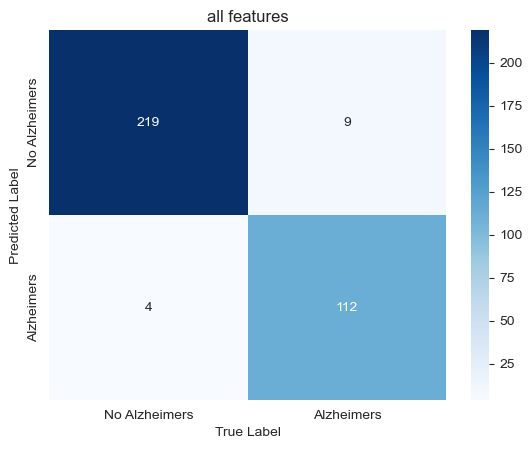

In [60]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_0,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

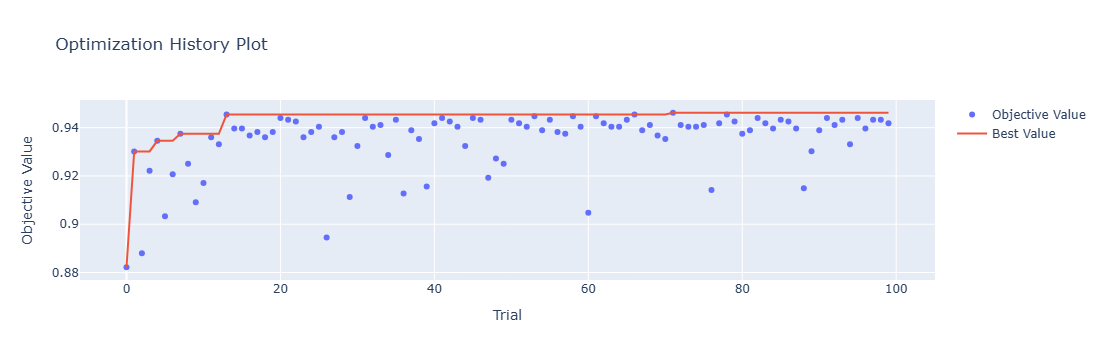

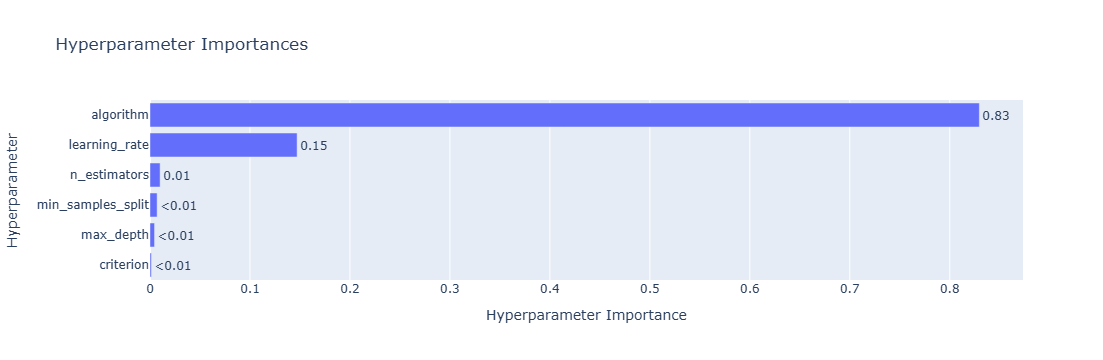

In [62]:
optuna.visualization.plot_optimization_history(study_0).show()
optuna.visualization.plot_param_importances(study_0).show()

We can also use the entire training set for fitting the model and compare the results.

In [64]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = accuracy_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_1 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_1.optimize(objective,n_trials=100)

print("best score: ", study_1.best_value)
print("best params ", study_1.best_params)

[I 2025-04-12 09:07:17,078] A new study created in memory with name: no-name-22459d5e-6a06-403b-8b8c-a77ef0ec0407
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:07:18,462] Trial 0 finished with value: 0.9505813953488372 and parameters: {'n_estimators': 84, 'learning_rate': 0.990428766805957, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}. Best is trial 0 with value: 0.9505813953488372.
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:07:23,227] Trial 1 finished with value: 0.9302325581395349 and parameters: {'n_estimators': 169, 'learning_rate': 0.528

best accuracy:  0.9651162790697675
best params  {'n_estimators': 181, 'learning_rate': 0.22632219920836547, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}


In [66]:
model_1_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}
model_1_ada_params = {'n_estimators': 181, 'learning_rate': 0.22632219920836547, 'algorithm': 'SAMME'}
model_1 = AdaBoostClassifier(**model_1_ada_params,estimator=DecisionTreeClassifier(**model_1_tree_params, random_state=123),random_state=123)

model_1.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_1 = model_1.predict(df_test[all_features[:-1]])

metrics_1 = [accuracy_score(preds_1,df_test.Diagnosis), 
             precision_score(preds_1,df_test.Diagnosis), 
             recall_score(preds_1,df_test.Diagnosis), 
             f1_score(preds_1,df_test.Diagnosis)]
model_1_scores = pd.DataFrame({'all_features': metrics_1})
model_1_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_1_scores

,all_features
Accuracy Score,0.965116
Precision Score,0.933884
Recall Score,0.965812
F1 Score,0.949580


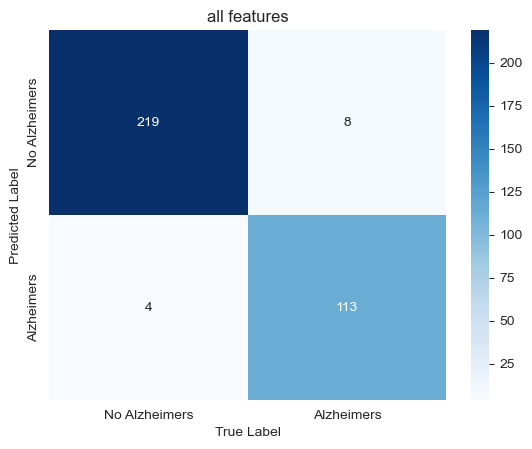

In [68]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_1,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

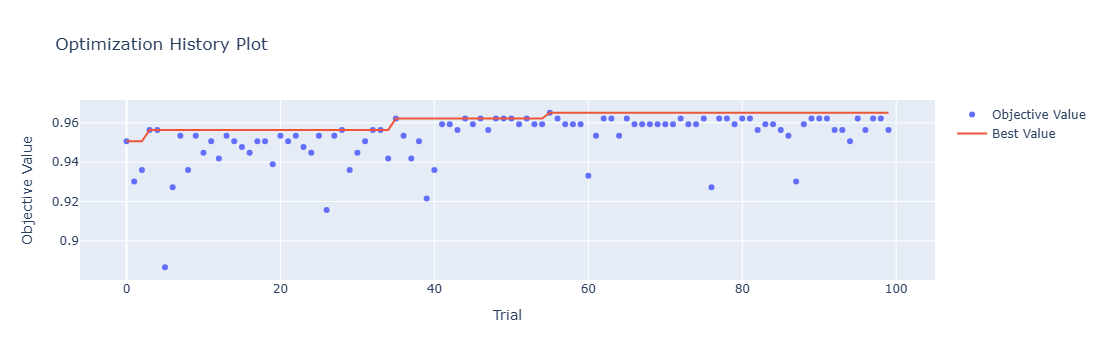

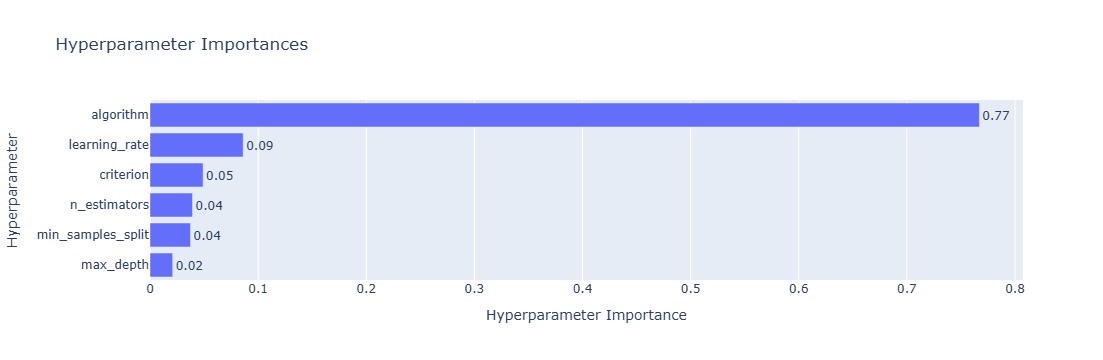

In [70]:
optuna.visualization.plot_optimization_history(study_1).show()
optuna.visualization.plot_param_importances(study_1).show()

### Optimizing `f1` score

In order to decrease the number of false negatives, we try to optimize the hyperparameters using other metrics that are more sensitive to the number of false negatives, namely `f1` score which is useful as a balanced metric for the cases when we have class imbalance.  

In [74]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = f1_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_2 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_2.optimize(objective,n_trials=100)

print("best score: ", study_2.best_value)
print("best params ", study_2.best_params)

[I 2025-04-12 09:22:45,989] A new study created in memory with name: no-name-aff0f8d3-4ae3-4d2b-8426-250e7c0b2ead
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:22:47,298] Trial 0 finished with value: 0.9173553719008265 and parameters: {'n_estimators': 89, 'learning_rate': 0.9038422778618782, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 17}. Best is trial 0 with value: 0.9173553719008265.
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:22:49,651] Trial 1 finished with value: 0.895397489539749 and parameters: {'n_estimators': 200, 'learning_rate': 0.20

best accuracy:  0.9535864978902954
best params  {'n_estimators': 144, 'learning_rate': 0.6466112988638498, 'algorithm': 'SAMME', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 12}


In [85]:
model_2_tree_params = {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 12}
model_2_ada_params = {'n_estimators': 144, 'learning_rate': 0.6466112988638498, 'algorithm': 'SAMME'}
model_2 = AdaBoostClassifier(**model_2_ada_params,estimator=DecisionTreeClassifier(**model_2_tree_params, random_state=123),random_state=123)

model_2.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_2 = model_2.predict(df_test[all_features[:-1]])

metrics_2 = [accuracy_score(preds_2,df_test.Diagnosis), 
             precision_score(preds_2,df_test.Diagnosis), 
             recall_score(preds_2,df_test.Diagnosis), 
             f1_score(preds_2,df_test.Diagnosis)]
model_2_scores = pd.DataFrame({'all_features': metrics_2})
model_2_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_2_scores

,all_features
Accuracy Score,0.968023
Precision Score,0.933884
Recall Score,0.974138
F1 Score,0.953586


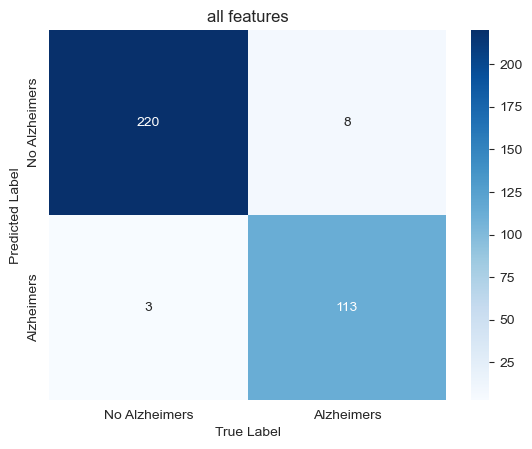

In [87]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_2,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

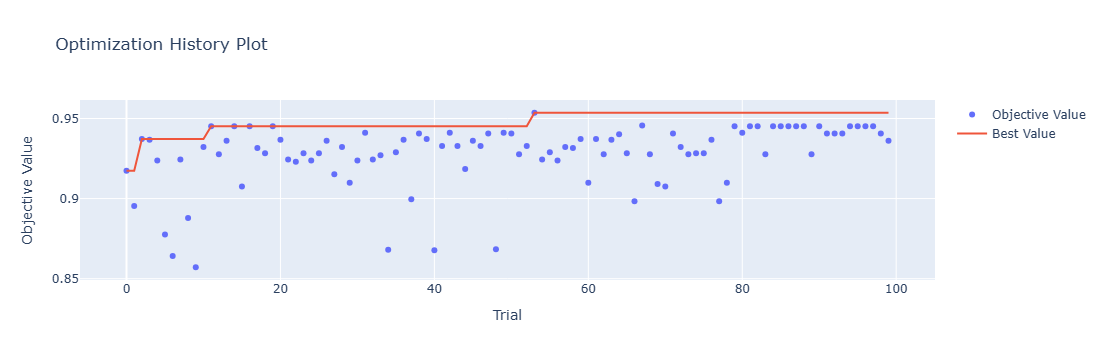

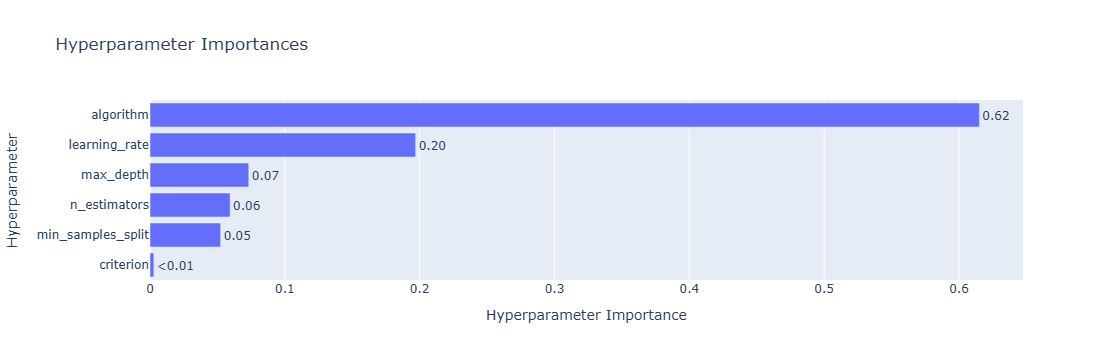

In [80]:
optuna.visualization.plot_optimization_history(study_2).show()
optuna.visualization.plot_param_importances(study_2).show()

### Optimizing `recall` score

We try to optimize `recall` score.

In [83]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = recall_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_3 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_3.optimize(objective,n_trials=100)

print("best score: ", study_3.best_value)
print("best params ", study_3.best_params)

[I 2025-04-12 09:43:49,852] A new study created in memory with name: no-name-d9240a08-21c9-4797-b3bf-c5a1f5367da1
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:43:52,370] Trial 0 finished with value: 0.9391304347826087 and parameters: {'n_estimators': 91, 'learning_rate': 0.10517169368251084, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20}. Best is trial 0 with value: 0.9391304347826087.
[I 2025-04-12 09:43:53,841] Trial 1 finished with value: 0.9224137931034483 and parameters: {'n_estimators': 123, 'learning_rate': 0.6176334646817004, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 7}. Best is trial 0 with value: 0.9391304347826087.
[I 2025-04-12 09:43:54,597] Trial 2 finished with value: 0.923728813559322 and 

best accuracy:  0.9655172413793104
best params  {'n_estimators': 111, 'learning_rate': 0.1674569455652402, 'algorithm': 'SAMME', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 16}


In [89]:
model_3_tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 16}
model_3_ada_params = {'n_estimators': 111, 'learning_rate': 0.1674569455652402, 'algorithm': 'SAMME'}
model_3 = AdaBoostClassifier(**model_3_ada_params,estimator=DecisionTreeClassifier(**model_3_tree_params, random_state=123),random_state=123)

model_3.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_3 = model_3.predict(df_test[all_features[:-1]])

metrics_3 = [accuracy_score(preds_3,df_test.Diagnosis), 
             precision_score(preds_3,df_test.Diagnosis), 
             recall_score(preds_3,df_test.Diagnosis), 
             f1_score(preds_3,df_test.Diagnosis)]
model_3_scores = pd.DataFrame({'all_features': metrics_3})
model_3_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_3_scores

,all_features
Accuracy Score,0.962209
Precision Score,0.925620
Recall Score,0.965517
F1 Score,0.945148


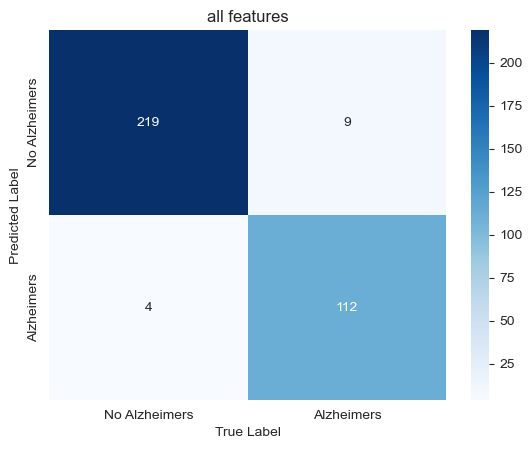

In [91]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_3,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

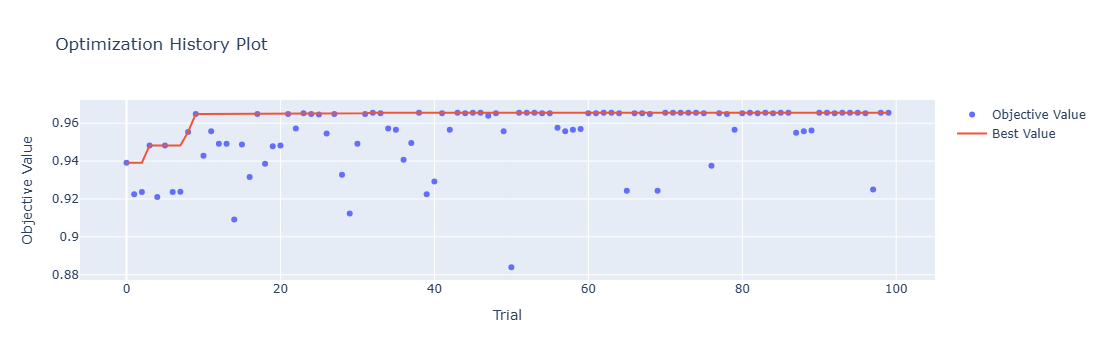

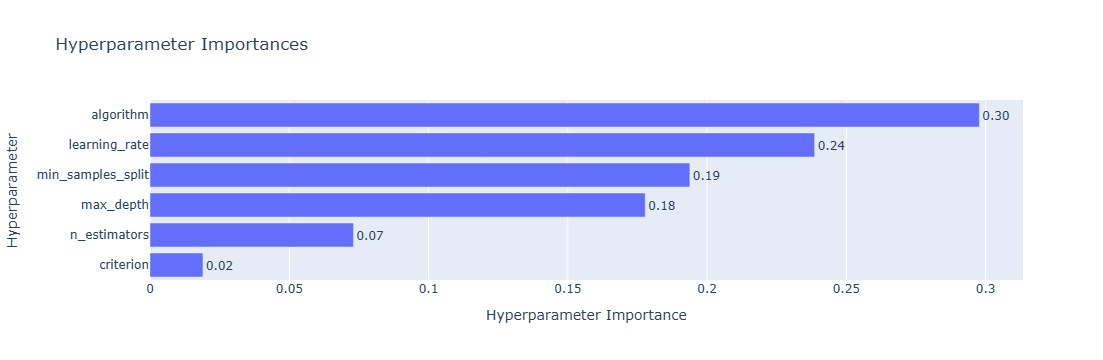

In [93]:
optuna.visualization.plot_optimization_history(study_3).show()
optuna.visualization.plot_param_importances(study_3).show()

### Optimizing `precision` score

We try to optimize `precision` score.

In [96]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = precision_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_4 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_4.optimize(objective,n_trials=100)

print("best score: ", study_4.best_value)
print("best params ", study_4.best_params)

[I 2025-04-12 09:54:48,218] A new study created in memory with name: no-name-28cc24ef-77db-419e-bade-030b94e38494
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 09:54:49,786] Trial 0 finished with value: 0.8264462809917356 and parameters: {'n_estimators': 76, 'learning_rate': 0.6949841112960288, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.8264462809917356.
[I 2025-04-12 09:54:52,193] Trial 1 finished with value: 0.9008264462809917 and parameters: {'n_estimators': 126, 'learning_rate': 0.26878776877010174, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 3}. Best is trial 1 with value: 0.9008264462809917.
[I 2025-04-12 09:54:55,238] Trial 2 finished with value: 0.9008264462809917 and 

best accuracy:  0.9504132231404959
best params  {'n_estimators': 130, 'learning_rate': 0.26971280658002783, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19}


In [104]:
model_4_tree_params = {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19}
model_4_ada_params = {'n_estimators': 130, 'learning_rate': 0.26971280658002783, 'algorithm': 'SAMME.R'}
model_4 = AdaBoostClassifier(**model_4_ada_params,estimator=DecisionTreeClassifier(**model_4_tree_params, random_state=123),random_state=123)

model_4.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_4 = model_4.predict(df_test[all_features[:-1]])

metrics_4 = [accuracy_score(preds_4,df_test.Diagnosis), 
             precision_score(preds_4,df_test.Diagnosis), 
             recall_score(preds_4,df_test.Diagnosis), 
             f1_score(preds_4,df_test.Diagnosis)]
model_4_scores = pd.DataFrame({'all_features': metrics_4})
model_4_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_4_scores

C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



,all_features
Accuracy Score,0.970930
Precision Score,0.950413
Recall Score,0.966387
F1 Score,0.958333


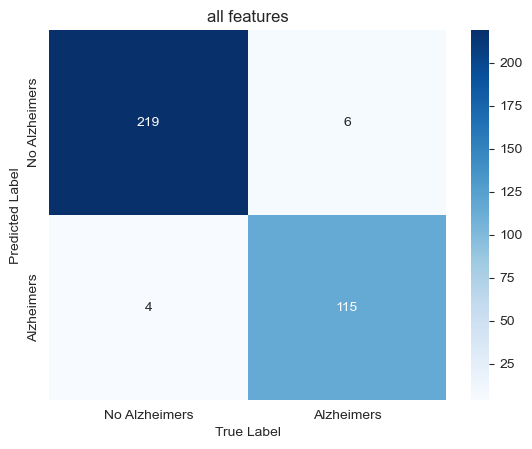

In [106]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_4,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

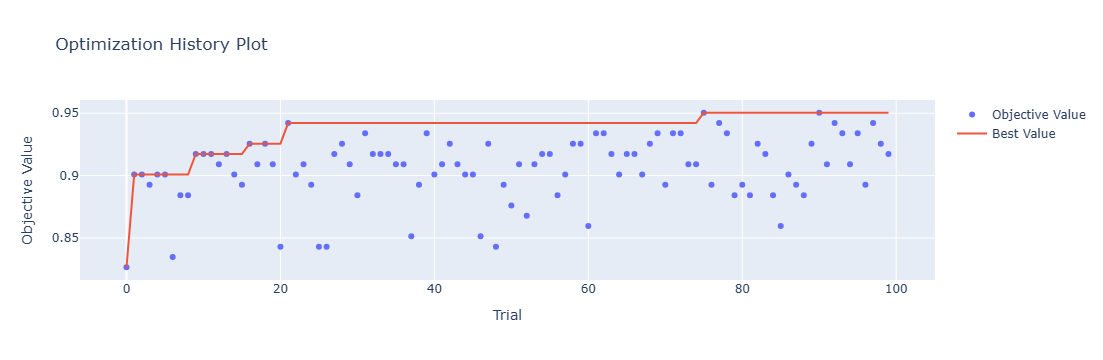

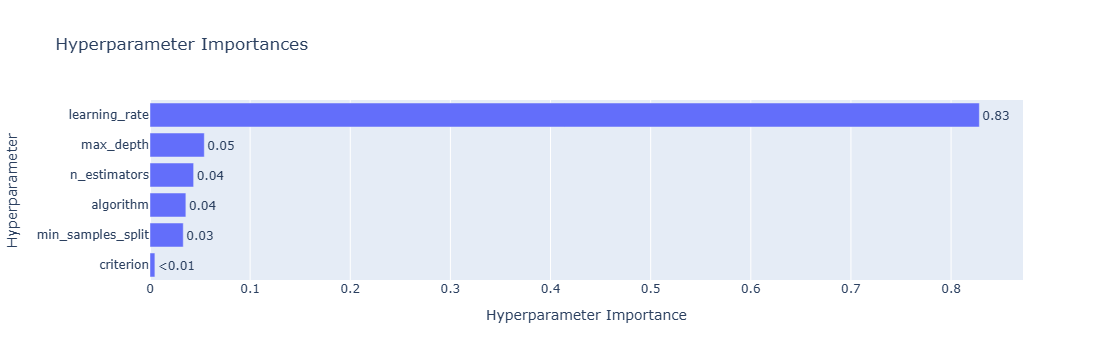

In [108]:
optuna.visualization.plot_optimization_history(study_4).show()
optuna.visualization.plot_param_importances(study_4).show()

## Summary of **AdaBoost** hyperparameter tuning

In [212]:
## Table of the metrics for each tuned model
ada_metrics_df = pd.DataFrame({'model_1': metrics_1 , 'model_2': metrics_2, 'model_3': metrics_3, 'model_4': metrics_4})
ada_metrics_df.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
ada_metrics_df

,model_1,model_2,model_3,model_4
Accuracy Score,0.965116,0.968023,0.962209,0.970930
Precision Score,0.933884,0.933884,0.925620,0.950413
Recall Score,0.965812,0.974138,0.965517,0.966387
F1 Score,0.949580,0.953586,0.945148,0.958333


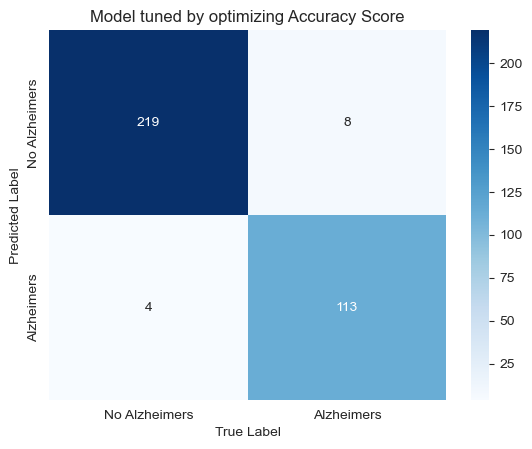

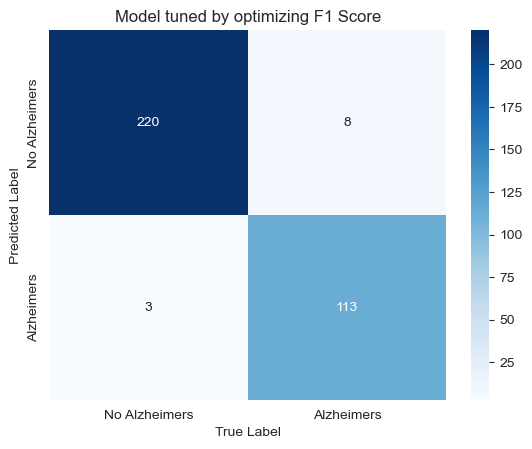

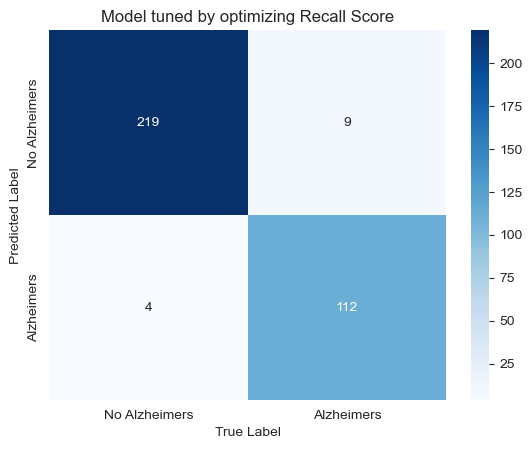

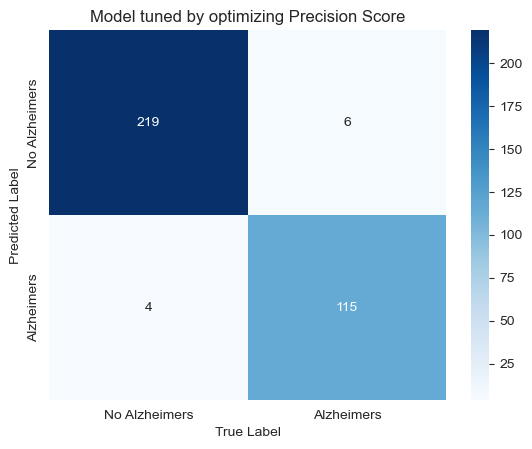

In [113]:
## Confusion matrices for each model
metric_labels = ['Accuracy Score', 'F1 Score' , 'Recall Score', 'Precision Score']
preds = [preds_1, preds_2, preds_3, preds_4]
for i in range(len(preds)):
    sns.heatmap(confusion_matrix(preds[i],df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
    plt.gca().set_title('Model tuned by optimizing '+ metric_labels[i])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.show()
    

## Tuning **XGBoost** On the Entire Dataset

In [156]:
## Installing XGBoost
!pip install xgboost

In [159]:
## Importing model
import xgboost
from xgboost import XGBClassifier

We tune the following core parameters in the **XGBoost** classifier model:
- `n_estimators`
- `learning_rate`
- `max_depth`
- `min_child_weight`
- `gamma`
- `subsample`
- `colsample_bytree`
- `eval_metric`

Also, we tune the following regularization parameters:
- `reg_alpha`
- `reg_lambda`
- `scale_pos_weight`

### Optimizing `accuracy` score

In [162]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = accuracy_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_5 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_5.optimize(objective,n_trials=100)

print("best score: ", study_5.best_value)
print("best params ", study_5.best_params)

[I 2025-04-12 15:58:45,609] A new study created in memory with name: no-name-a92e3037-d602-470e-8bc8-4ca8931b27a8
[I 2025-04-12 15:58:46,391] Trial 0 finished with value: 0.9215116279069767 and parameters: {'n_estimators': 721, 'learning_rate': 0.20900215100987282, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 3, 'subsample': 0.8044001782161285, 'colsample_bytree': 0.9079414080052348, 'reg_alpha': 0.1617581127039942, 'reg_lambda': 0.4995509284537488, 'scale_pos_weight': 44, 'eval_metric': 'error'}. Best is trial 0 with value: 0.9215116279069767.
[I 2025-04-12 15:58:46,973] Trial 1 finished with value: 0.9127906976744186 and parameters: {'n_estimators': 384, 'learning_rate': 0.18595410088835646, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0, 'subsample': 0.6794413293697303, 'colsample_bytree': 0.6639550934829662, 'reg_alpha': 0.6516981092940899, 'reg_lambda': 0.08606156325070435, 'scale_pos_weight': 56, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.9215116279069767.
[I 2025

best accuracy:  0.9651162790697675
best params  {'n_estimators': 478, 'learning_rate': 0.11695740910607914, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 4, 'subsample': 0.8471131268794714, 'colsample_bytree': 0.8328744815379274, 'reg_alpha': 0.599755540800184, 'reg_lambda': 0.31593650763447745, 'scale_pos_weight': 4, 'eval_metric': 'auc'}


In [164]:
model_5_params = {'n_estimators': 478, 'learning_rate': 0.11695740910607914, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 4, 'subsample': 0.8471131268794714, 'colsample_bytree': 0.8328744815379274, 'reg_alpha': 0.599755540800184, 'reg_lambda': 0.31593650763447745, 'scale_pos_weight': 4, 'eval_metric': 'auc'}
model_5 = XGBClassifier(**model_5_params,random_state=123)

model_5.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_5 = model_5.predict(df_test[all_features[:-1]])

metrics_5 = [accuracy_score(preds_5,df_test.Diagnosis), 
             precision_score(preds_5,df_test.Diagnosis), 
             recall_score(preds_5,df_test.Diagnosis), 
             f1_score(preds_5,df_test.Diagnosis)]
model_5_scores = pd.DataFrame({'all_features': metrics_5})
model_5_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_5_scores

,all_features
Accuracy Score,0.965116
Precision Score,0.933884
Recall Score,0.965812
F1 Score,0.949580


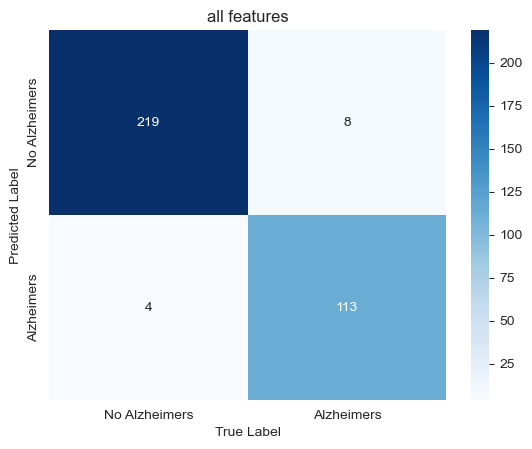

In [166]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_5,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

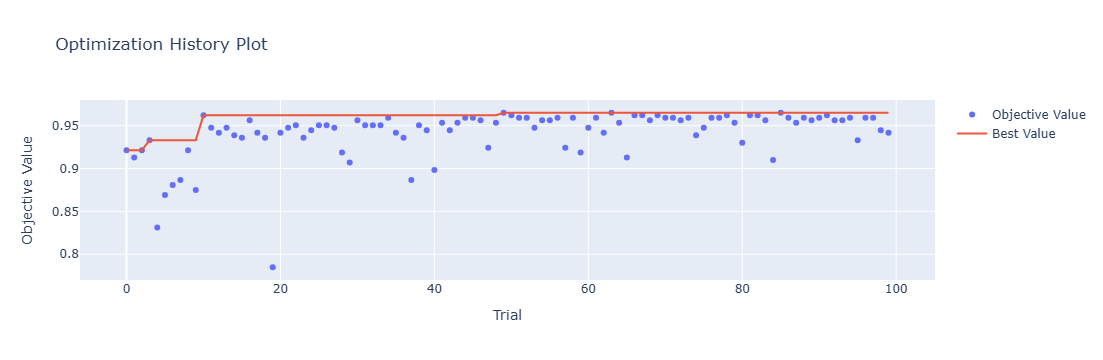

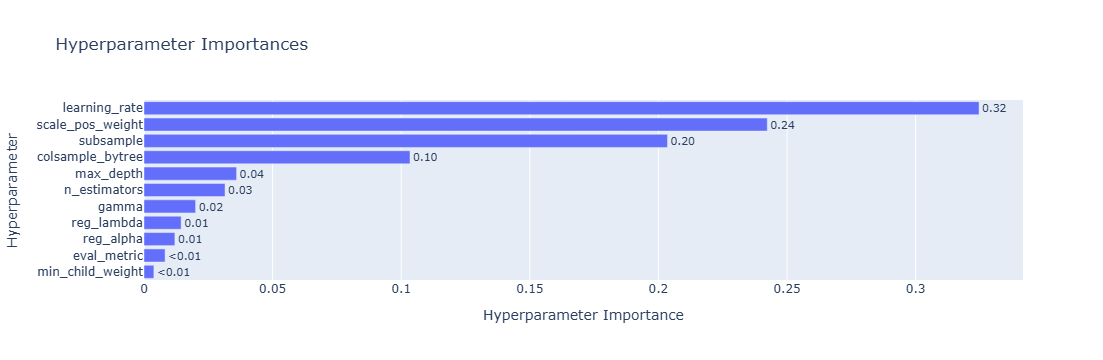

In [170]:
optuna.visualization.plot_optimization_history(study_5).show()
optuna.visualization.plot_param_importances(study_5).show()

### Optimizing `f1` score

In [173]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = f1_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_6 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_6.optimize(objective,n_trials=100)

print("best score: ", study_6.best_value)
print("best params ", study_6.best_params)

[I 2025-04-12 16:15:13,007] A new study created in memory with name: no-name-18a5b68e-cd7a-4936-9dc2-a2375dada2c0
[I 2025-04-12 16:15:13,909] Trial 0 finished with value: 0.8984375 and parameters: {'n_estimators': 923, 'learning_rate': 0.11735932243959743, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 5, 'subsample': 0.9635368871497496, 'colsample_bytree': 0.8016630184155484, 'reg_alpha': 0.033915739381514154, 'reg_lambda': 0.6750563718152913, 'scale_pos_weight': 67, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.8984375.
[I 2025-04-12 16:15:15,399] Trial 1 finished with value: 0.8648648648648649 and parameters: {'n_estimators': 804, 'learning_rate': 0.26106584633584146, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0, 'subsample': 0.5425360035211657, 'colsample_bytree': 0.6579915163001546, 'reg_alpha': 0.20731141077366455, 'reg_lambda': 0.39975846186014796, 'scale_pos_weight': 94, 'eval_metric': 'error'}. Best is trial 0 with value: 0.8984375.
[I 2025-04-12 16:15:15,830] Tri

best accuracy:  0.95
best params  {'n_estimators': 602, 'learning_rate': 0.039830452299156896, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.7828738024524255, 'colsample_bytree': 0.6220394608069365, 'reg_alpha': 0.8172447991553283, 'reg_lambda': 0.9181798354793087, 'scale_pos_weight': 4, 'eval_metric': 'error'}


In [181]:
model_6_params = {'n_estimators': 602, 'learning_rate': 0.039830452299156896, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.7828738024524255, 'colsample_bytree': 0.6220394608069365, 'reg_alpha': 0.8172447991553283, 'reg_lambda': 0.9181798354793087, 'scale_pos_weight': 4, 'eval_metric': 'error'}
model_6 = XGBClassifier(**model_6_params,random_state=123)

model_6.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_6 = model_6.predict(df_test[all_features[:-1]])

metrics_6 = [accuracy_score(preds_6,df_test.Diagnosis), 
             precision_score(preds_6,df_test.Diagnosis), 
             recall_score(preds_6,df_test.Diagnosis), 
             f1_score(preds_6,df_test.Diagnosis)]
model_6_scores = pd.DataFrame({'all_features': metrics_6})
model_6_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_6_scores

,all_features
Accuracy Score,0.965116
Precision Score,0.942149
Recall Score,0.957983
F1 Score,0.950000


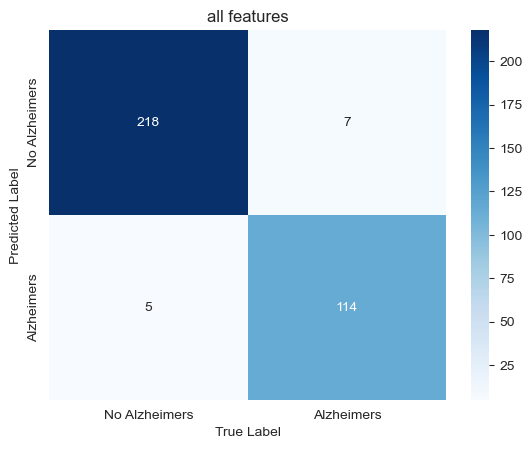

In [183]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_6,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

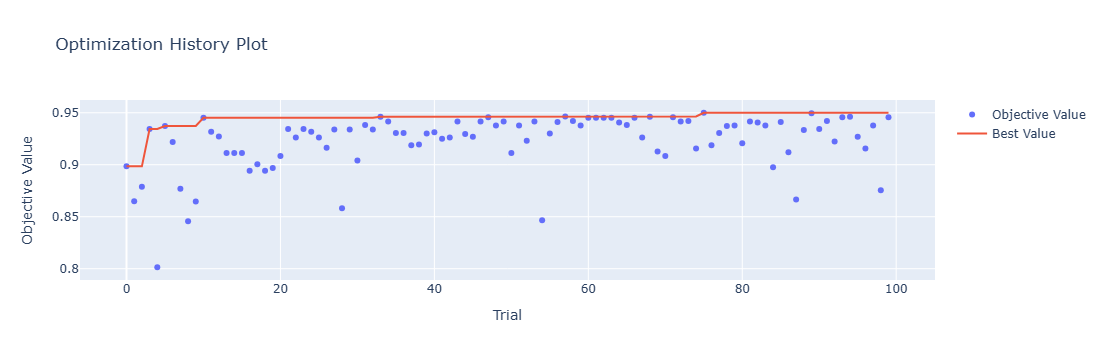

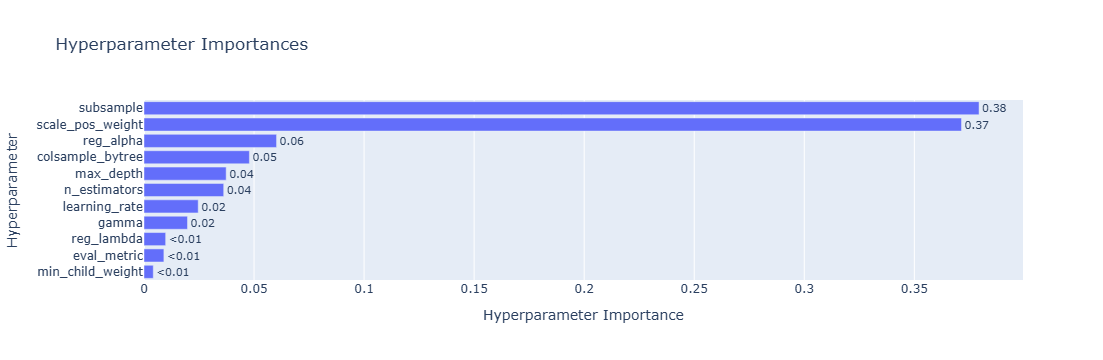

In [185]:
optuna.visualization.plot_optimization_history(study_6).show()
optuna.visualization.plot_param_importances(study_6).show()

### Optimizing `recall` score

In [187]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = recall_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_7 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_7.optimize(objective,n_trials=100)

print("best score: ", study_7.best_value)
print("best params ", study_7.best_params)

[I 2025-04-12 16:21:31,154] A new study created in memory with name: no-name-429bce29-a0ed-4d33-b694-35ec37667cc4
[I 2025-04-12 16:21:31,499] Trial 0 finished with value: 0.8248175182481752 and parameters: {'n_estimators': 326, 'learning_rate': 0.288148665113199, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 3, 'subsample': 0.7945081279340407, 'colsample_bytree': 0.6489510855227212, 'reg_alpha': 0.5819625860217982, 'reg_lambda': 0.08707896918848479, 'scale_pos_weight': 16, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.8248175182481752.
[I 2025-04-12 16:21:32,492] Trial 1 finished with value: 0.8057553956834532 and parameters: {'n_estimators': 699, 'learning_rate': 0.24371503387909596, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0, 'subsample': 0.7172866969160056, 'colsample_bytree': 0.6986960536823934, 'reg_alpha': 0.5497094727483464, 'reg_lambda': 0.050868549255675743, 'scale_pos_weight': 86, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.8248175182481752.


best accuracy:  0.9732142857142857
best params  {'n_estimators': 746, 'learning_rate': 0.08226172994201762, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0, 'subsample': 0.8696326695253096, 'colsample_bytree': 0.617892526779344, 'reg_alpha': 0.16531848002591149, 'reg_lambda': 0.5168704522480313, 'scale_pos_weight': 1, 'eval_metric': 'auc'}


In [189]:
model_7_params = {'n_estimators': 746, 'learning_rate': 0.08226172994201762, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0, 'subsample': 0.8696326695253096, 'colsample_bytree': 0.617892526779344, 'reg_alpha': 0.16531848002591149, 'reg_lambda': 0.5168704522480313, 'scale_pos_weight': 1, 'eval_metric': 'auc'}
model_7 = XGBClassifier(**model_7_params,random_state=123)

model_7.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_7 = model_7.predict(df_test[all_features[:-1]])

metrics_7 = [accuracy_score(preds_7,df_test.Diagnosis), 
             precision_score(preds_7,df_test.Diagnosis), 
             recall_score(preds_7,df_test.Diagnosis), 
             f1_score(preds_7,df_test.Diagnosis)]
model_7_scores = pd.DataFrame({'all_features': metrics_7})
model_7_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_7_scores

,all_features
Accuracy Score,0.956395
Precision Score,0.900826
Recall Score,0.973214
F1 Score,0.935622


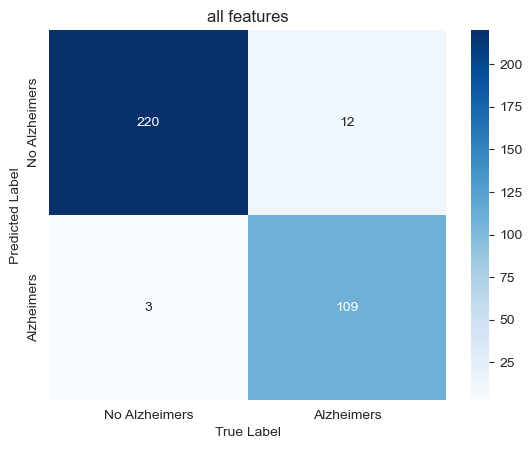

In [191]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_7,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

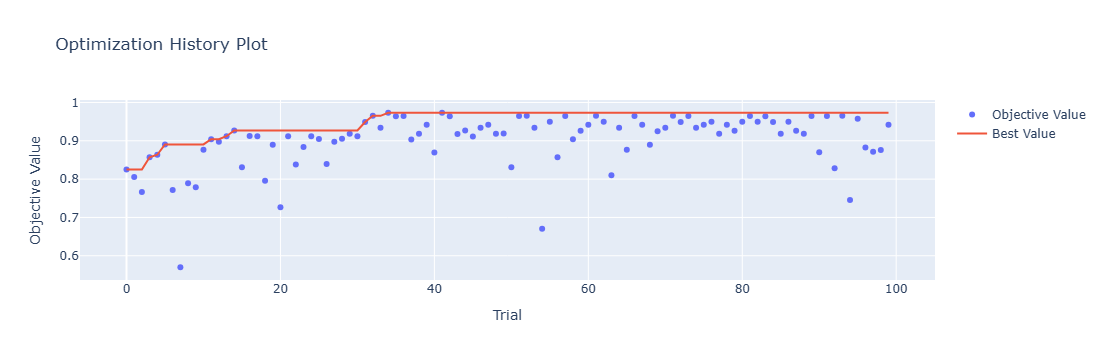

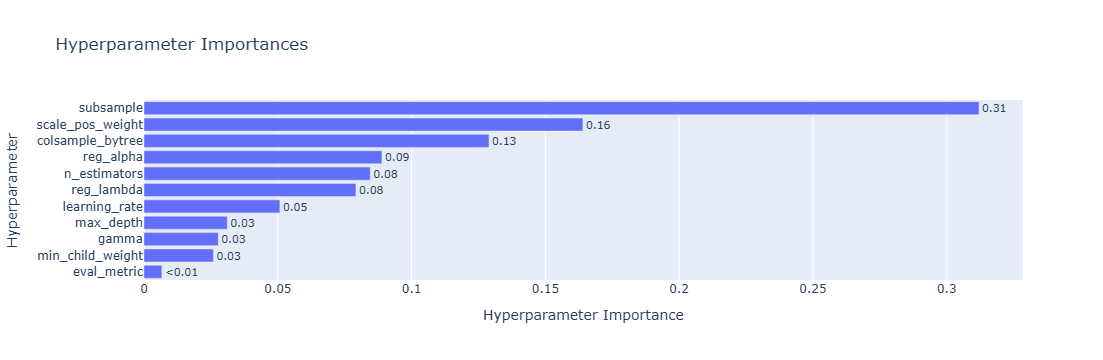

In [193]:
optuna.visualization.plot_optimization_history(study_7).show()
optuna.visualization.plot_param_importances(study_7).show()

### Optimizing `precision` score

In [195]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = precision_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_8 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_8.optimize(objective,n_trials=100)

print("best score: ", study_8.best_value)
print("best params ", study_8.best_params)

[I 2025-04-12 16:29:15,957] A new study created in memory with name: no-name-5c338ac8-b22e-4e37-9d47-68f162c0afae
[I 2025-04-12 16:29:16,659] Trial 0 finished with value: 0.9338842975206612 and parameters: {'n_estimators': 790, 'learning_rate': 0.2378478137613789, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 3, 'subsample': 0.9347525116399172, 'colsample_bytree': 0.9197184216963457, 'reg_alpha': 0.3930798226085104, 'reg_lambda': 0.47059870101356416, 'scale_pos_weight': 71, 'eval_metric': 'error'}. Best is trial 0 with value: 0.9338842975206612.
[I 2025-04-12 16:29:17,217] Trial 1 finished with value: 0.9421487603305785 and parameters: {'n_estimators': 461, 'learning_rate': 0.20612990697039174, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 3, 'subsample': 0.6763644563850795, 'colsample_bytree': 0.6543729962790886, 'reg_alpha': 0.030015147030439282, 'reg_lambda': 0.9789799403539913, 'scale_pos_weight': 25, 'eval_metric': 'error'}. Best is trial 1 with value: 0.9421487603305785.
[I

best accuracy:  0.9752066115702479
best params  {'n_estimators': 469, 'learning_rate': 0.25447433275406706, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 5, 'subsample': 0.9150645807757931, 'colsample_bytree': 0.6358636677821979, 'reg_alpha': 0.6503501707048663, 'reg_lambda': 0.9613767287607515, 'scale_pos_weight': 45, 'eval_metric': 'error'}


In [197]:
model_8_params = {'n_estimators': 469, 'learning_rate': 0.25447433275406706, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 5, 'subsample': 0.9150645807757931, 'colsample_bytree': 0.6358636677821979, 'reg_alpha': 0.6503501707048663, 'reg_lambda': 0.9613767287607515, 'scale_pos_weight': 45, 'eval_metric': 'error'}
model_8 = XGBClassifier(**model_8_params,random_state=123)

model_8.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_8 = model_8.predict(df_test[all_features[:-1]])

metrics_8 = [accuracy_score(preds_8,df_test.Diagnosis), 
             precision_score(preds_8,df_test.Diagnosis), 
             recall_score(preds_8,df_test.Diagnosis), 
             f1_score(preds_8,df_test.Diagnosis)]
model_8_scores = pd.DataFrame({'all_features': metrics_8})
model_8_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_8_scores

,all_features
Accuracy Score,0.875000
Precision Score,0.975207
Recall Score,0.746835
F1 Score,0.845878


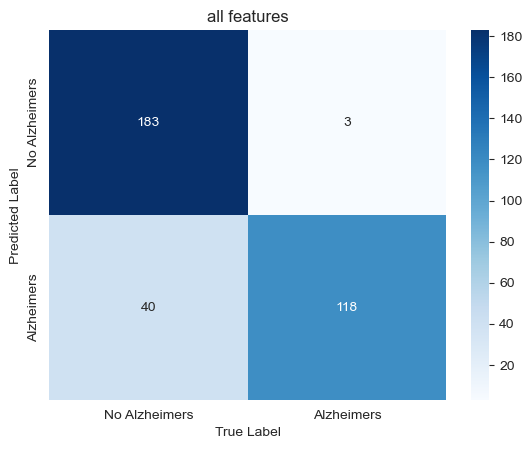

In [201]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_8,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

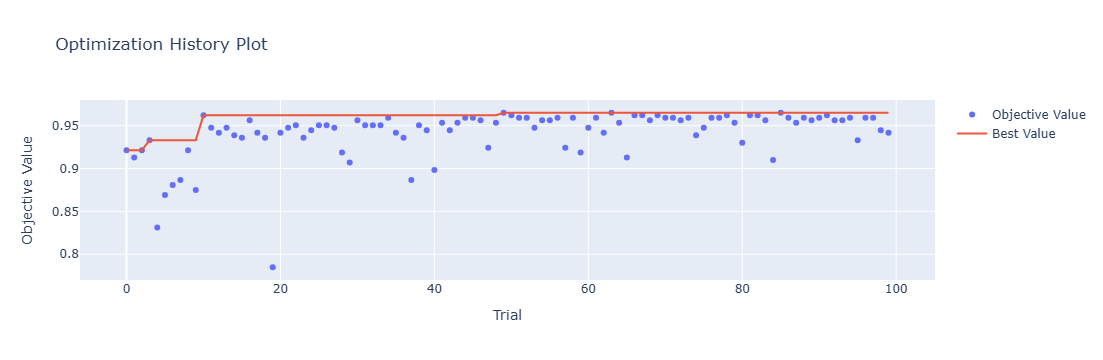

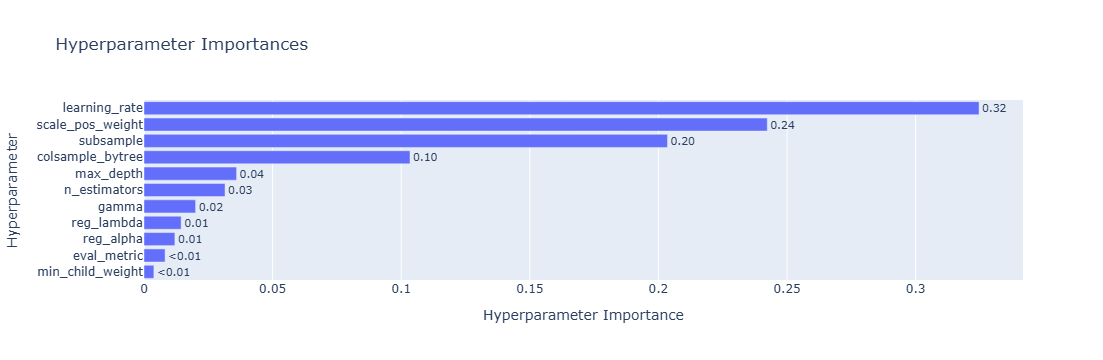

In [170]:
optuna.visualization.plot_optimization_history(study_8).show()
optuna.visualization.plot_param_importances(study_8).show()

## Summary of **XGBoost** hyperparameter tuning

In [215]:
## Table of the metrics for each tuned model
xgb_metrics_df = pd.DataFrame({'model_5': metrics_5 , 'model_6': metrics_6, 'model_7': metrics_7, 'model_8': metrics_8})
xgb_metrics_df.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
xgb_metrics_df

,model_5,model_6,model_7,model_8
Accuracy Score,0.965116,0.965116,0.956395,0.875000
Precision Score,0.933884,0.942149,0.900826,0.975207
Recall Score,0.965812,0.957983,0.973214,0.746835
F1 Score,0.949580,0.950000,0.935622,0.845878


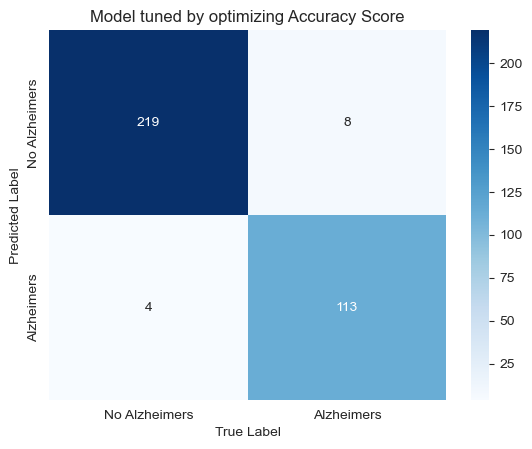

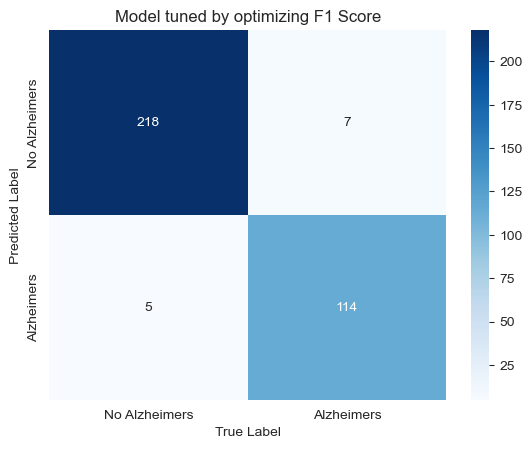

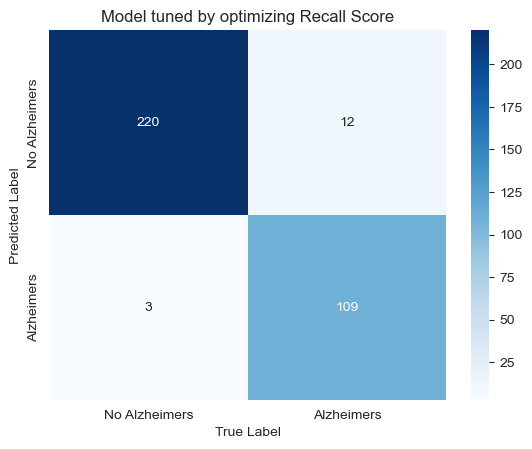

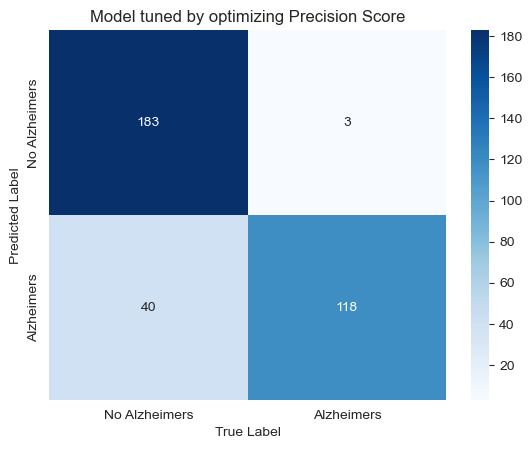

In [217]:
## Confusion matrices for each model
metric_labels = ['Accuracy Score', 'F1 Score' , 'Recall Score', 'Precision Score']
preds = [preds_5, preds_6, preds_7, preds_8]
for i in range(len(preds)):
    sns.heatmap(confusion_matrix(preds[i],df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
    plt.gca().set_title('Model tuned by optimizing '+ metric_labels[i])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.show()
    

# Conclusion

We can compare the performance of tuned **AdaBoost** vs tuned **XGBoost** models:

In [227]:
pd.concat([ada_metrics_df, xgb_metrics_df],axis = 1)

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Accuracy Score,0.965116,0.968023,0.962209,0.970930,0.965116,0.965116,0.956395,0.875000
Precision Score,0.933884,0.933884,0.925620,0.950413,0.933884,0.942149,0.900826,0.975207
Recall Score,0.965812,0.974138,0.965517,0.966387,0.965812,0.957983,0.973214,0.746835
F1 Score,0.949580,0.953586,0.945148,0.958333,0.949580,0.950000,0.935622,0.845878


It seems that `model_4` is the best-performing model overall. Here, we record the model hyperparameters for future reference.

In [230]:
model_tuned_tree_params = {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19}
model_tuned_ada_params = {'n_estimators': 130, 'learning_rate': 0.26971280658002783, 'algorithm': 'SAMME.R'}
model_tuned_ = AdaBoostClassifier(**model_4_ada_params,estimator=DecisionTreeClassifier(**model_4_tree_params, random_state=123),random_state=123)
